In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import time

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [2]:
quantiles_path = f"../out-data/feb18_51/quantiles.csv"
anomalies_paths = [
    f"../post-analysis/405/ee/all_405/bin_mark_confirmed.csv",
    f"../post-analysis/405/if/all_405/bin_mark_confirmed.csv",
    f"../post-analysis/405/lof/all_405/bin_mark_confirmed.csv",
]

In [3]:
quantiles = pd.read_csv(quantiles_path, index_col=0)
quantiles

,sloc,relativeLoc,nodeCount,cstHeight,maxLoopNestingDepth,cyclomaticComplexity,designComplexity,numTypecastExpr,numMethodCalls,numStatementExpressions,...,numOperationReferences,numThrows,numSafeExpressions,numClassLiterals,numCollectionLiterals,numZeroConstants,numOneConstants,numEmptyStringLiterals,numPlusOperations,avgNumWhenEntries
0.000,-4.0,0.000014,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.001,1.0,0.000086,6.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.005,1.0,0.000363,6.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.010,1.0,0.000634,6.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.500,3.0,0.084034,60.0,8.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.990,41.0,0.888889,795.0,27.0,1.0,9.0,5.0,2.0,29.0,18.0,...,19.0,1.0,3.0,1.0,0.0,3.0,3.0,1.0,3.0,3.0
0.995,55.0,0.937500,1069.0,30.0,1.0,11.0,7.0,3.0,39.0,24.0,...,27.0,1.0,4.0,2.0,0.0,4.0,4.0,2.0,5.0,5.0
0.999,104.0,1.000000,2069.0,39.0,2.0,24.0,14.0,6.0,75.0,56.0,...,57.0,3.0,10.0,4.0,0.0,10.0,10.0,4.0,12.0,9.0
1.000,5899.0,1.000000,106132.0,368.0,12.0,1985.0,1001.0,362.0,4110.0,1830.0,...,6564.0,57.0,1195.0,133.0,18.0,2245.0,2898.0,408.0,4705.0,570.0


In [4]:
header = ['id', 'signature'] + list(quantiles)

def load(path):
    return pd.read_csv(path, delimiter=',', quoting=csv.QUOTE_MINIMAL, error_bad_lines=True,
                       engine='python', header=None, names=header, index_col=0)

temp_dfs = [load(path) for path in anomalies_paths]
data = pd.concat(temp_dfs, axis=0, join='outer').drop_duplicates()
del temp_dfs

print(data.shape)
data.head()

(322, 52)


,signature,sloc,relativeLoc,nodeCount,cstHeight,maxLoopNestingDepth,cyclomaticComplexity,designComplexity,numTypecastExpr,numMethodCalls,...,numOperationReferences,numThrows,numSafeExpressions,numClassLiterals,numCollectionLiterals,numZeroConstants,numOneConstants,numEmptyStringLiterals,numPlusOperations,avgNumWhenEntries
id,,,,,,,,,,,,,,,,,,,,,
43125,repos/TinJenda__ChatKotlin/app/src/main/java/c...,310.0,0.499220,6142.0,46.0,1.0,1.0,1.0,0.0,204.0,...,141.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,5.0,0.0
669372,repos/carlphilipp__crypto-tracker/back-end/res...,9.0,0.140625,265.0,9.0,0.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
669373,repos/carlphilipp__crypto-tracker/back-end/res...,7.0,0.109375,179.0,9.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
669374,repos/carlphilipp__crypto-tracker/back-end/res...,7.0,0.109375,179.0,9.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
669380,repos/carlphilipp__crypto-tracker/back-end/res...,6.0,0.461538,195.0,15.0,0.0,1.0,1.0,0.0,2.0,...,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0


In [27]:
data.to_csv("../post-analysis/report_322.csv")

In [5]:
# selected_data = data.iloc[:, 2:]

selected_labels = ['cstHeight','maxLoopNestingDepth','cyclomaticComplexity','designComplexity','numTypecastExpr','numMethodCalls','numStatementExpressions','numReturns','numValueParameters','numLoopStatements','numTypeParameters','maxNumWhenEntries','numIfExprs','numAssigns','numNestedFuns','numNestedClasses','numDeclarations','numBlocks','numTry','numCatch','numFinally','numForceUnwraps','numLambdas','numAnnotations','numKeywords','numDistinctKeywords','maxNumBlockChildren','numEmptyBlocks','numConstExpr','numStringTemplates','numReferences','numOperationReferences','numThrows','numSafeExpressions','numClassLiterals','numCollectionLiterals','numZeroConstants','numOneConstants','numEmptyStringLiterals','numPlusOperations']
selected_data = data.loc[:, selected_labels]

X = scale(selected_data)

In [6]:
# 2D visualization

def draw2(colors='blue'):
    X_2 = PCA(n_components=2).fit_transform(X)
    plt.figure(figsize=(12, 8))
    plt.scatter(X_2[:, 0], X_2[:, 1], c=colors, marker='o')
    plt.show()

In [7]:
# 3D visualization

def draw3(colors='blue'):
    X_3 = PCA(n_components=3).fit_transform(X)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_3[:, 0], X_3[:, 1], X_3[:, 2], c=colors, marker='o')
    plt.show()

In [11]:
linkage = "ward"
n_clusters = 20
clt_conf = f"agg_{linkage}_{n_clusters}"
clt = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters)
clt.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=20,
            pooling_func=<function mean at 0x1075a3048>)

In [69]:
clt_conf = "categ_dbscan_eps-0.3"
clt = DBSCAN(eps=0.3)
clt.fit(X)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

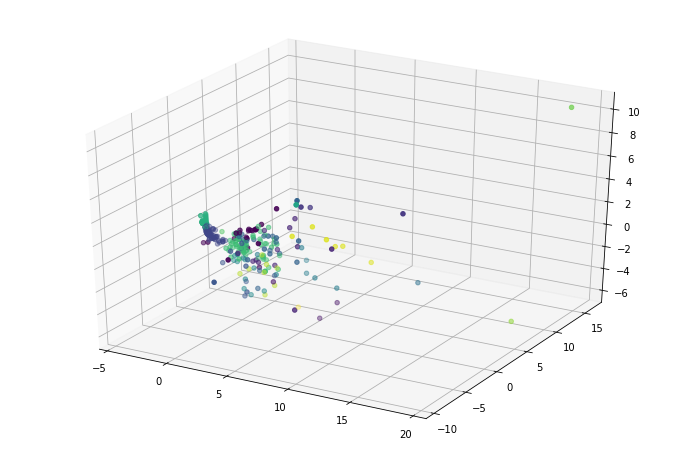

In [12]:
draw3(clt.labels_)

In [13]:
labels = pd.DataFrame(clt.labels_)
df = pd.DataFrame(np.hstack((data, labels)), index=data.index)
df.to_csv(f"../post-analysis/categ/{clt_conf}.csv", header=None)

In [93]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
id,,,,,,,,,,,,,,,,,,,,,
43125,repos/TinJenda__ChatKotlin/app/src/main/java/c...,310,0.49922,6142,46,1,1,1,0,204,...,0,0,6,0,0,0,0,5,0,1
669372,repos/carlphilipp__crypto-tracker/back-end/res...,9,0.140625,265,9,0,1,1,0,2,...,0,0,0,2,0,0,0,0,0,1
669373,repos/carlphilipp__crypto-tracker/back-end/res...,7,0.109375,179,9,0,1,1,0,1,...,0,0,0,2,0,0,0,0,0,1
669374,repos/carlphilipp__crypto-tracker/back-end/res...,7,0.109375,179,9,0,1,1,0,1,...,0,0,0,2,0,0,0,0,0,1
669380,repos/carlphilipp__crypto-tracker/back-end/res...,6,0.461538,195,15,0,1,1,0,2,...,0,0,0,3,0,0,0,2,0,1
